# Bikeshare Analysis
Rowan Cassius – September, 2019

## Excective Summary

Careful and deliberate analysis of the bike share data has discovered meaningful insights regarding trip duration, seasonality of bike rides and variation in bike availabilty on a daily basis.

On the basis of these insights, we strongly recommend that Ford GoBike implement the following changes in order to boost ridership in the bikeshare system:

1. Offer monthly memberships in addition to annual memberships.
2. Offer consistent daily discounts from the single trip flat rate according to the hour of the day at all stations universally. Sensible candidates for the hours of discounted flat rates are:
    * Offering a "Night Owl" discount for riding between `8pm` and `6am`
    * Offering a "Midday" discount for riding between `10am` and `3pm` 
3. Remove or extend the trip duration constraint associated with the day pass.

Together these changes are likely to:
1. Increase the number of subscribers.
2. Increase the number of trips at unpopular riding times.
3. Result in longer trips and happier customers.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# The Data
### Schema of the bike trips dataset

* `trip_id`
    * Numeric ID of bike trip
* `duration_sec`
    * Time of trip in seconds
* `start_date`	
    * date of trip with date and time, in PST
* `start_station_name`
    * Station name of start station
* `start_station_id`
    * Numeric reference for start station
* `end_date`
    * End date of trip with date and time, in PST
* `end_station_name`
    * Station name for end station
* `end_station_id`
    * Numeric reference for end station
* `bike_number`
    * ID of bike used
* `zip_code`
    * Home zip code of subscriber (customers can choose to manually enter zip at kiosk however data is unreliable)
* `subscriber_type`
    * Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member
    
### Schema of the bike stations dataset
* `station_id`
    * Numeric reference for the station
* `docks_available`
    * Number of docks available at the given time
* `bikes_available`
    * Number of bikes available at the given time
* `time`
    * Time of cross section
* `total_bikes`
    * The capacity of the station

##  Part 1. Determine the most popular commuter trips.

Chosen criteria for a commuter trip:
* Start station and end station are different
* Occurs at a popular commute time so as to enable attendance at a routine obligation
    * popular commute times:
         * morning commute time, `7am-10am`
         * evening commute time, `5pm-8pm`
* Occurs on a weekday
    * `M`, `Tu`, `W`, `Th`, `F` 
    

Notice that these commute time criteria target "9-5" jobs.


### Trip count of commuter trips by start and end stations

In [8]:
# See Query A in Appendix
df_pop_trips

,start_station_name,end_station_name,number
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4038
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3909
2,Steuart at Market,2nd at Townsend,3179
3,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,2863
4,Market at Sansome,2nd at South Park,2834
5,Steuart at Market,Embarcadero at Sansome,2730
6,Mountain View Caltrain Station,Mountain View City Hall,2572
7,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),2488
8,San Francisco Caltrain 2 (330 Townsend),Market at 10th,2337
9,San Francisco Caltrain (Townsend at 4th),Howard at 2nd,2238


Clearly, 4 of the top 10 commuter trips begin at one of the San Francisco Caltrain stations. I suspect that this is likely due to the volume of San Francisco residents working day jobs along in the Peninsula, which is most easily reached via Caltrain.

Finally, the top 5 commuter trips occuring on weekdays between the hours of `7am-10am` and `5pm-8pm` and begin and end at the following stations:

## Top 5 Commuter Trips

In [9]:
df_pop_trips[["start_station_name", "end_station_name"]].head(6).shift()[1:]

,start_station_name,end_station_name
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th
3,Steuart at Market,2nd at Townsend
4,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome
5,Market at Sansome,2nd at South Park


# Part 2. Increase Ridership.

Ford GoBike's current pricing scheme includes the following options:
1. A flat price for a single one-way trip
2. A day pass that allows unlimited 30-minute rides for 24 hours
3. An annual membership



To begin thinking about increasing ridership, it is worthwhile to establish a definition of ridership that lends itself to being measured.

Ridership is naturally a bounded notion. Ridership has a practical upper bound as follows: If, in a given week, every bike were being ridden at every moment of the week, then ridership would be at a maximum in said week.

This insight, while somewhat trivial, lends itself to defining _ridership for a given week_ as deterministically related to: _"The averge time use time over all the bikes"_

We can express this in clearer notation with the following definitions:
* Let $B_w$ denote the finite set of operative bikes in week $w$.
* Let $t_{i,w}$ denote the amount of time (in minutes) for which bike $i$ was in use in week $w$.
* Let $R_w = \sum_{i \in B} t_{i,w}$ then meaure ridership in week $w$.
* Notice that the natural bound for Ridership discussed earlier is $ R_w \leq |B_w|\cdot T$, where $T$ is the number of minutes in a week.

Finally, given the understanding of ridership on a given week as _the averge time use time over all the bikes_, notice that attempting to increase ridership is equivalent to decreasing the _the collective amount of time that bikes spend unused_. This identificaiton will inform the approch taken in the rest of this report to increasing ridership.

## Inferences about the data
The `subscriber_type` field has the following clarification: "_Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member_". Since this is inconsistent with the current pricing scheme in the problem statement, I am inferring that the desctiption is out of date, and that the following holds:
* A `customer` has either paid a flat price for one trip or has paid for a day pass.
* A `subscriber` has paid for an annual membership.

## Trip Duration in Minutes

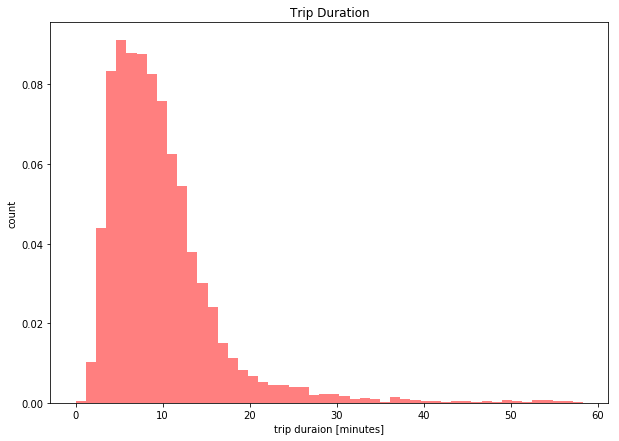

In [10]:
# See Query B in Appendix
upper_lim = np.percentile(a = df_duration["duration_min"], q = 97)
plt.figure(figsize=(10, 7))
plt.hist(x = df_duration["duration_min"], range = (0, upper_lim), bins = 50, alpha = 0.5, color = 'red', density = True)
plt.title('Trip Duration')
plt.ylabel('count')
plt.xlabel('trip duraion [minutes]')

plt.show()

## Trip Duration by Subscriber Type

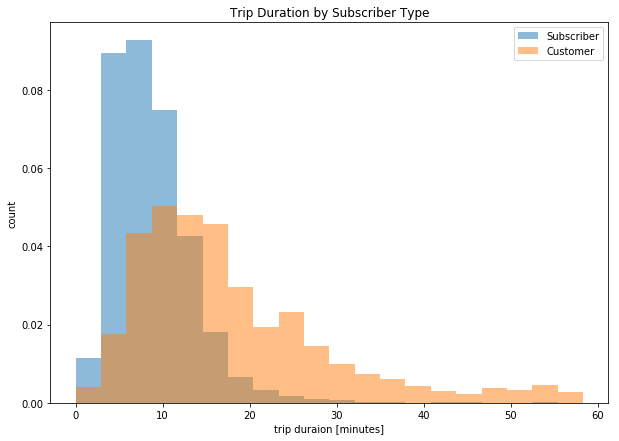

In [11]:
lims, bins, alpha, lw, dens = (0, upper_lim), 20, 0.5, 0, True
plt.figure(figsize=(10, 7))
sub_duration = df_duration[df_duration["subscriber_type"]=='Subscriber']["duration_min"]
cus_duration = df_duration[df_duration["subscriber_type"]=='Customer']["duration_min"]
plt.hist(x = sub_duration, label = 'Subscriber',
         range = lims, bins = bins, alpha = alpha, lw = lw, density = dens)
plt.hist(x = cus_duration, label = 'Customer',
         range = lims, bins = bins, alpha = alpha, lw = lw, density = dens)
plt.title('Trip Duration by Subscriber Type')
plt.ylabel('count')
plt.xlabel('trip duraion [minutes]')
plt.legend(loc='upper right')

plt.show()

### Is there a significant differenece between the median trip duarations of customer trips and subscriber trips?

In [12]:
# Use the Mann Whitney U test because the distributions do not look normal
from scipy.stats import mannwhitneyu

test = mannwhitneyu(sub_duration, cus_duration, alternative='less')
test.pvalue

0.0

A non-parametric hyopthesis test strongly rejects the null hypothesis that subscribers and customers have the same median trip duration at the 1% alpha level and accepts the alternative that customers have a higher median trip duration.

In [13]:
# Calculate the percentage of trips over 30 minutes done by customers
over_30_trips = df_duration[df_duration['duration_min'] >= 30]

print('percentage of trips over 30 minutes done by customers:')
over_30_trips[over_30_trips['subscriber_type'] == 'Customer'].shape[0]/over_30_trips.shape[0]

percentage of trips over 30 minutes done by customers:


0.8713080168776371

Additionally, The particularly long right tail of the trip durations of customers is noteworthy. 87% of trips that are over 30 minutes long are done by customers.

# Rides by Time of Day

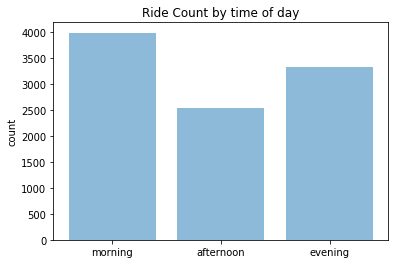

In [14]:
counts = df_duration['time_of_day'].value_counts().reindex(['morning', 'afternoon', 'evening'])

y_pos = np.arange(len(counts))
performance = counts

plt.bar(counts.index, counts, align='center', alpha=0.5)
plt.xticks(y_pos, counts.index)
plt.ylabel('count')
plt.title('Ride Count by time of day')

plt.show()

The chart above suggests that bike use through out the day may not be uniformly distributed. This leads us to take another look at how much bikes are being used at each hour of the day. However, as mentioned previously, this information is also contained in examining how much bikes are not being used throughout the day. So, instead, this report will examine how a very popular station's capacity fluctuates throughout the day.

## Available Bikes by hour of day

As mentioned previously, the goal of increasing ridership is equivalent to decreasing the collective amount of time in a day that bikes spend unused. The following section will examine the inactivity of bikes throughout the day.



To start this dicussion, let's find out which stations are the most important.

In [15]:
def cumulation_index(nums, p):
    """Returns the first index by which at least propotion p of the data has accumulated"""
    cdf = np.cumsum(nums)/np.sum(nums)
    index = np.argwhere(cdf >= p).flatten()[0] # get the first index
    
    return index

In [16]:
# Get the most important starting and ending stations
start_station_counts = df_duration['start_station_name'].value_counts()
end_station_counts = df_duration['end_station_name'].value_counts()

# get the top stations responsible for at least 50% of trip starts and ends
p = 0.5
imp_start_stations = start_station_counts.index[:cumulation_index(start_station_counts.values, p)]
imp_end_stations = end_station_counts.index[:cumulation_index(end_station_counts.values, p)]
imp_stations = np.union1d(imp_start_stations, imp_end_stations)

# get the important stations associated ids
name_to_id = pd.Series(df_duration.start_station_id.values,index=df_duration.start_station_name.values).to_dict()
id_to_name = dict(map(reversed, name_to_id.items()))
imp_station_ids = [name_to_id[name] for name in imp_stations]

The following stations alone are the ports for at least 50% of all bike ride activity. In this sense they are the most important startions.

### Stations accounting for more than 50% of all bike activity:

In [17]:
pd.DataFrame({'station_name': imp_stations})

,station_name
0,2nd at Townsend
1,Embarcadero at Sansome
2,Harry Bridges Plaza (Ferry Building)
3,Market at 10th
4,Market at 4th
5,Market at Sansome
6,San Francisco Caltrain (Townsend at 4th)
7,San Francisco Caltrain 2 (330 Townsend)
8,Steuart at Market
9,Temporary Transbay Terminal (Howard at Beale)


In [18]:
print("Station id of 2nd at Townsend, one of the most active stations daily: ", name_to_id["2nd at Townsend"])

Station id of 2nd at Townsend, one of the most active stations daily:  61


In [19]:
# See Query C in Appendix for df_station
df_hour = df_station.groupby('hour').mean()

## Available bikes on average for the most popular station by hour of day.

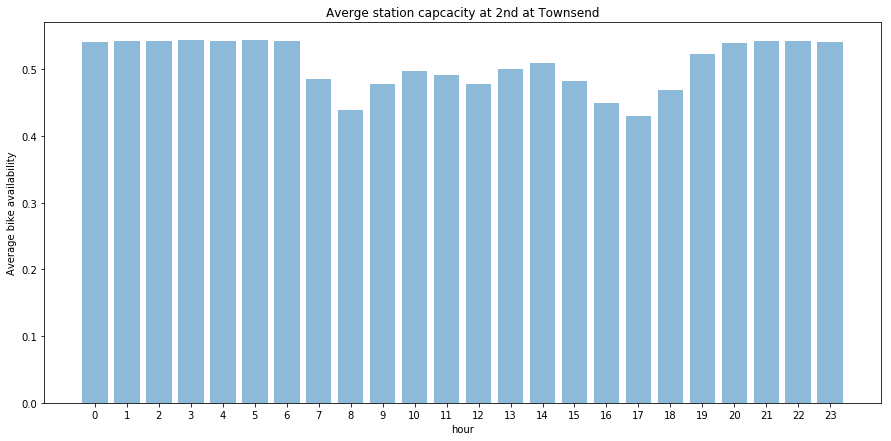

In [20]:
plt.figure(figsize=(15, 7))
plt.bar(df_hour.index, df_hour['capacity'], align='center', alpha=0.5)
plt.xticks(df_hour.index)
plt.xlabel('hour')
plt.ylabel('Average bike availability')
plt.title('Averge station capcacity at ' + imp_stations[0])
plt.show()

From the chart it is clear that 2nd and Townend experiences significant fluctuation in average bike availability throughout the day. In the early hour of the morning and in the late hours of the evening, 55% of the docks at 2nd and Townsend tend to be available. At 8pm and 5pm, the station expereinces a drop in bike availablity most likely due to commuter usage. However, at mid-day between the hours of 10 and 2pm, there tends to be an abundance of available bikes. To increase bike usage and ridership, it would be safe and effective to incentivize the usage of bikes at these hours of the day of high bike availability.

### Which stations experience the highest fluctuations of bike availability?
2nd and Townsend is an example of a station which experiences noticabele fluctuation in bike availablity on average throughout a typical day. Next, we look at which stations experience the most fluctuation.

In [23]:
# See Query D in Appendix for df_fluctuation
# add column containing station names associated with station ids
df_fluctuation['station'] = df_fluctuation.apply(lambda row: id_to_name.get(row['station_id'], "na"), axis = 1)

### The following stations experice the highest fluctuations in bike availability on average throughout the day.

In [24]:
df_fluctuation[['station']].head(5)

,station
0,San Francisco Caltrain (Townsend at 4th)
1,San Francisco Caltrain 2 (330 Townsend)
2,Grant Avenue at Columbus Avenue
3,Harry Bridges Plaza (Ferry Building)
4,Embarcadero at Bryant


It appears that SF Caltrain (Townsend at 4th) experiences the greatest fluctuations in bike availability.

In [25]:
# See Query E in Appendix
df_hour_70 = df_station.groupby('hour').mean()

## Available bike percentage on average for SF Caltrain (townsend at 4th)

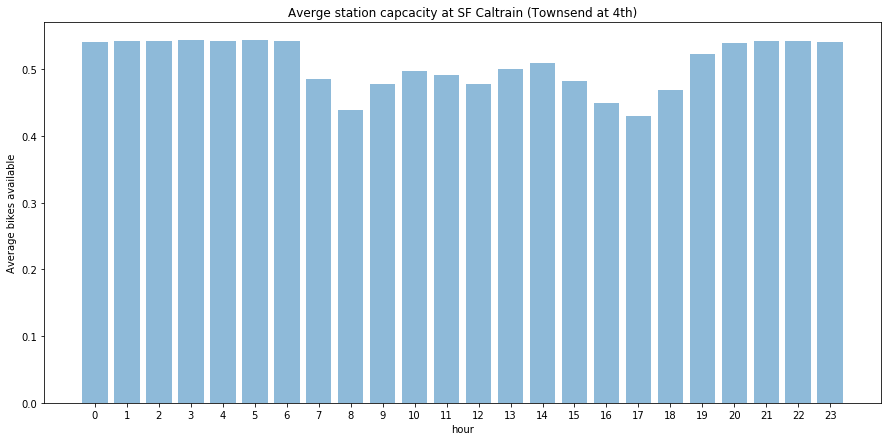

In [26]:
plt.figure(figsize=(15, 7))
plt.bar(df_hour_70.index, df_hour['capacity'], align='center', alpha=0.5)
plt.xticks(df_hour_70.index)
plt.xlabel('hour')
plt.ylabel('Average bikes available')
plt.title('Averge station capcacity at ' + 'SF Caltrain (Townsend at 4th)')
plt.show()

# Rides by Month

Now, we briefly turn to looking at ride count by month in order to determine whether rides is at all seasonal.

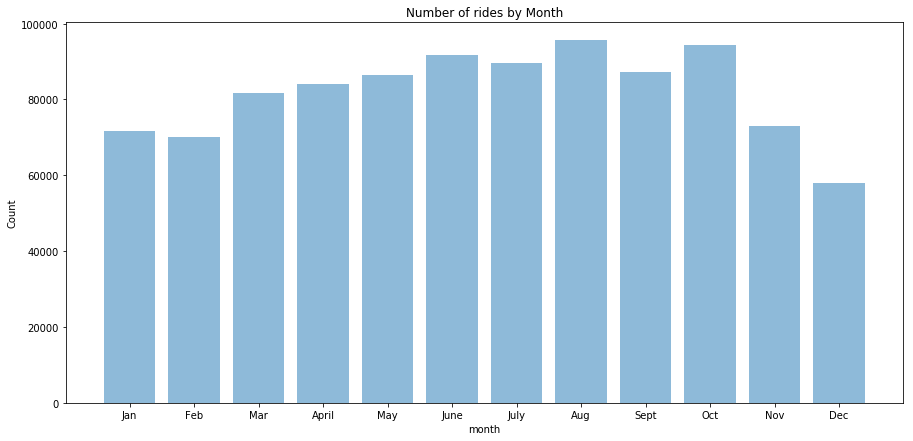

In [27]:
# See Query F in Appendix
plt.figure(figsize=(15, 7))
plt.bar(df_month.index, df_month['cnt'], align='center', alpha=0.5)
plt.xticks(df_month.index)
plt.xlabel('month')
plt.ylabel('Count')
plt.title('Number of rides by Month')
plt.show()

### Are ride count and month independent variables?

In [28]:
from scipy.stats import chisquare

test = chisquare(df_month['cnt'].values)
test.pvalue

0.0

From a simple chi-square test of homogeneity, we can strongly reject the null hypothesis that the number of rides in a given month is independent of the month at the 1% significance level, and we can accept the alternaitve hypothesis that says month and ride count are dependent. This conclusion is consistent with the visual difference in ride counts over each month of the year. In winter there appers to be a decrease in trip count.

# Recommendations.


### Recommendation for increasing subscribers.
According to a chisquare test of uniformity, there is a highly significant dependence between what month it is and the number of rides which occur in that month. In other words, seasonality has a significant impact on bike usage. Thus, creating a monthly membership pass, as opposed to only offering a annual pass, will accommodate the seasonal preferences of riders and result in more subscribers.

### Recommendation for increasing bike trips.
There are clear fluctuations in the average percentage of occupied docks at each station throughout the day. When the percantage of occupied docks is high at a given station, there is both a need to redistribute the bikes to other stations and a valuable opportunity to increase ridership. At stations which regularly experience moments of high bike station occupation, Ford GoBike can offer discounts on rides starting at such stations. 

When offering a discounted ride at station $x$ a an hour of the day in which the station is periodically fuller than usual, it is reasonable to expect that the rides originating from station $x$ at said hour will certainly not decrease on average. Instead, they will more likely increase. As a result, station $x$ is likely to experience greater use.

It should be noted that this suggestion primarily targets riders paying for single rides because subscribers with annual memberships will be agnostic to the dynamic pricing of single rides. 

This suggestion can be implemented in two different ways. 
1. Discounts for single rides can be offered at different hours of the day for each station.
2. Discounts for single rides can be offered at the same hours of the day for all stations univerally.

While option 1. would theoretically result in discounts that would meet the needs of bike redistribution and ridership augmentation better, customers may find the discounts annoying inconsistent accross different stations at a particular time of the day, espcially since the discounts would be offered in the middle of the day between 10am and 2pm, which is not a commuting time. Therefore, option 2 has the strength of providing an easy-to-remember discount that is consistent across all stations. 


### Recommendation for increasing trip durations.
From the analysis of trip duaration, it was determined that customers have a significantly higher median trip duration than subscribers do. This is unsurprising because many subscribers are probably using the bikes for a commuting routine. In the rides of customers paying a flat price for a single ride or for a single day of unlimited 30 minute rides, there is an opportunity to increase the usage of bikes by allowing longer trips. 

Since customers tend to enjoy longer rides, and 88% of rides over 30 minutes are done by customers, removing the 30 minute duration constraint for the day pass or extending it to 60 minutes would enable customers to take longer and more leisurely rides. It is reasonable to say that the customers who use day passes will certainly not ride for less time on average in response to this change. Instead, they will more likely have longer and happier rides, thus increasing ridership according to the metric established earlier in this notebook.

# Summary of Recommendations:
This report offers three core recommendations:

1. Offer monthly memberships in addition to annual memberships.
2. Offer consistent daily discounts from the single trip flat rate according to the hour of the day at all stations universally. Sensible candidates for the hours of discounted flat rates are:
    * Offering a "Night Owl" discount for riding between `8pm` and `6am`
    * Offering a "Midday" discount for riding between `10am` and `3pm` 
3. Remove or extend the trip duration constraint associated with the day pass.

Together these changes are likely to:
1. Increase the number of subscribers.
2. Increase the number of trips at unpopular riding times.
3. Result in longer trips and happier customers.

## Query Appendix.

#### Query A: 
Querying the trips that meet the criteria for a commuter trip.

QUERY:
```
WITH  commuter_tbl AS 
    (SELECT * FROM 
        (SELECT *, EXTRACT(HOUR FROM start_date) AS start_hour, EXTRACT(HOUR FROM end_date) AS end_hour 
            FROM `my-test-project-251101.bike_trip_data.bike_trips`) 
        WHERE (start_hour > 7 AND end_hour < 10) OR 
              (start_hour > 17 AND end_hour < 20) AND EXTRACT(DAYOFWEEK FROM start_date) <= 5) 
SELECT start_station_name, end_station_name, COUNT(*) AS number 
    FROM commuter_tbl 
         GROUP BY start_station_name, end_station_name ORDER BY COUNT(*) DESC LIMIT 10

```

In [2]:
# Query A
! bq query --use_legacy_sql=FALSE --format=csv 'WITH  commuter_tbl AS (SELECT * FROM (SELECT *, EXTRACT(HOUR FROM start_date) AS start_hour, EXTRACT(HOUR FROM end_date) AS end_hour FROM `my-test-project-251101.bike_trip_data.bike_trips`) WHERE (start_hour > 7 AND end_hour < 10) OR (start_hour > 17 AND end_hour < 20) AND EXTRACT(DAYOFWEEK FROM start_date) <= 5) SELECT start_station_name, end_station_name, COUNT(*) AS number FROM commuter_tbl GROUP BY start_station_name, end_station_name ORDER BY COUNT(*) DESC LIMIT 10' > result.csv
df_pop_trips = pd.read_csv('result.csv')

Waiting on bqjob_r21472a09bb184d06_0000016d98423a6d_1 ... (1s) Current status: DONE   

#### Query B
Querying the trips that qualify as commuter trips.

QUERY:
```
WITH hour_tbl AS 
    (SELECT *, EXTRACT(HOUR FROM end_date) AS end_hour, EXTRACT(DAYOFWEEK FROM end_date) AS day_of_week 
        FROM `my-test-project-251101.bike_trip_data.bike_trips`) 
SELECT *, duration_sec/60 as duration_min, 
    CASE WHEN end_hour < 12 THEN "morning" 
         WHEN end_hour < 17 THEN "afternoon" 
         ELSE "evening" END AS time_of_day, 
    CASE WHEN day_of_week <=5 THEN "weekday" 
         ELSE "weekend" END AS week_time 
    FROM hour_tbl WHERE RAND() < 0.01' > result_2.csv
```

In [3]:
# Query B
! bq query --use_legacy_sql=FALSE --format=csv --max_rows=10000 'WITH hour_tbl AS (SELECT *, EXTRACT(HOUR FROM end_date) AS end_hour, EXTRACT(DAYOFWEEK FROM end_date) AS day_of_week FROM `my-test-project-251101.bike_trip_data.bike_trips`) SELECT *, duration_sec/60 as duration_min, CASE WHEN end_hour < 12 THEN "morning" WHEN end_hour < 17 THEN "afternoon" ELSE "evening" END AS time_of_day, CASE WHEN day_of_week <=5 THEN "weekday" ELSE "weekend" END AS week_time FROM hour_tbl WHERE RAND() < 0.01' > result_2.csv
df_duration = pd.read_csv('result_2.csv')

Waiting on bqjob_r702202ff63bba4f5_0000016d98424b7f_1 ... (2s) Current status: DONE   

#### Query C
Querying the station data from 2nd and Townsend, the most popular station

QUERY:

```
SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week, 
    bikes_available/(bikes_available + docks_available) AS capacity 
    FROM `my-test-project-251101.bike_trip_data.total_bikes` 
    WHERE station_id = 61
```

In [4]:
# Query C
! bq query --use_legacy_sql=FALSE --max_rows=100000000 --format=csv 'SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week, bikes_available/(bikes_available + docks_available) AS capacity FROM `my-test-project-251101.bike_trip_data.total_bikes` WHERE station_id = 61' > result_3.csv
df_station = pd.read_csv('result_3.csv')

Waiting on bqjob_r70ba856a5e4846d1_0000016d984265d3_1 ... (5s) Current status: DONE   

#### Query D
Queries the stations with highest to lowest standard deviation in bike availability throughout the day

QUERY:
```
WITH capacity_tbl AS 
    (SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week,
     bikes_available/(bikes_available + docks_available) AS capacity 
         FROM `my-test-project-251101.bike_trip_data.total_bikes` 
         WHERE bikes_available + docks_available > 0) 
SELECT station_id, STDDEV(capacity) AS sd_capacity 
    FROM capacity_tbl GROUP BY station_id ORDER BY STDDEV(capacity) DESC
```

In [22]:
# Query D
! bq query --use_legacy_sql=FALSE --max_rows=100000000 --format=csv 'WITH capacity_tbl AS (SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week, bikes_available/(bikes_available + docks_available) AS capacity FROM `my-test-project-251101.bike_trip_data.total_bikes` WHERE bikes_available + docks_available > 0) SELECT station_id, STDDEV(capacity) AS sd_capacity FROM capacity_tbl GROUP BY station_id ORDER BY STDDEV(capacity) DESC' > result_4.csv
df_fluctuation = pd.read_csv('result_4.csv')

Waiting on bqjob_rfcdcbb4a9d9d63d_0000016d984c1357_1 ... (0s) Current status: DONE   

#### Query E
Fetches the station data from SF Caltrain (Townsend at 4th), the station with the highest fluctuation

QUERY:
```
SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week, 
    bikes_available/(bikes_available + docks_available) AS capacity 
    FROM `my-test-project-251101.bike_trip_data.total_bikes` 
    WHERE station_id = 70
```

In [6]:
# Query E
! bq query --use_legacy_sql=FALSE --max_rows=100000000 --format=csv 'SELECT *, EXTRACT(HOUR FROM time) AS hour, EXTRACT(DAYOFWEEK FROM time) AS day_of_week, bikes_available/(bikes_available + docks_available) AS capacity FROM `my-test-project-251101.bike_trip_data.total_bikes` WHERE station_id = 70' > result_3.csv
df_station_70 = pd.read_csv('result_3.csv')
df_hour_70 = df_station.groupby('hour').mean()

Waiting on bqjob_r4047789b11788916_0000016d98450a40_1 ... (6s) Current status: DONE   

#### Query F
Fetch the ride counts by month

QUERY:
```
SELECT COUNT(*) as cnt, EXTRACT(MONTH FROM start_date) AS month 
    FROM `my-test-project-251101.bike_trip_data.bike_trips` 
    GROUP BY month' > result_5.csv
```

In [7]:
# Query F: 
! bq query --use_legacy_sql=FALSE --max_rows=100000000 --format=csv 'SELECT COUNT(*) as cnt, EXTRACT(MONTH FROM start_date) AS month FROM `my-test-project-251101.bike_trip_data.bike_trips` GROUP BY month' > result_5.csv
df_month = pd.read_csv('result_5.csv')

# Wrangling
months = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df_month = df_month.sort_values('month')
df_month.index = months

Waiting on bqjob_r6b7244ec3d1abe04_0000016d9847a5e6_1 ... (0s) Current status: DONE   